# NLP Project BIGRAM MODEL
#### CSCI 3832 Natural Language Processing
Members: Adam Wuth, Benjamin Kohav, Noah Vilas, Aiden Devine, Evan Zachary

### Requirements

In [1]:
import os, random, sys, copy
import torch, torch.nn as nn, numpy as np
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from datasets import load_dataset, concatenate_datasets, load_from_disk
from datetime import datetime

### Load in the data set
The dataset is split into categories, but we wanted all categories from 2020 onwards. This code block will take forever to run, only run it the first time to get the dataset. 

In [2]:
# #The dataset is split into categories

categories = [
    "All_Beauty",
    "Amazon_Fashion",
    "Appliances",
    "Arts_Crafts_and_Sewing",
    "Automotive",
    "Baby_Products",
    "Beauty_and_Personal_Care",
    "Books",
    "CDs_and_Vinyl",
    "Cell_Phones_and_Accessories",
    "Clothing_Shoes_and_Jewelry",
    "Digital_Music",
    "Electronics",
    "Gift_Cards",
    "Grocery_and_Gourmet_Food",
    "Handmade_Products",
    "Health_and_Household",
    "Health_and_Personal_Care",
    "Home_and_Kitchen",
    "Industrial_and_Scientific",
    "Kindle_Store",
    "Magazine_Subscriptions",
    "Movies_and_TV",
    "Musical_Instruments",
    "Office_Products",
    "Patio_Lawn_and_Garden",
    "Pet_Supplies",
    "Software",
    "Sports_and_Outdoors",
    "Subscription_Boxes",
    "Tools_and_Home_Improvement",
    "Toys_and_Games",
    "Video_Games",
    "Unknown"
]

# #to get reviews from 2023 onwards 2020 onwards was millions of reviews and was taking
# #over an hour just to load the data
# start_timestamp = int(datetime(2023, 1, 1).timestamp() * 1000)

# #to store all datasets
# allcats = []

# for cat in categories:
#     print(f"Loading category: {cat}")
#     dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{cat}", split="full[:150000]",  trust_remote_code=True)
#     #dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{cat}", split="full[:1%]",  trust_remote_code=True)
#    #dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", cat, split="full",  trust_remote_code=True) formatting issues
#     #get the 2023 onwards and add to data
#     filtered_dataset = dataset.filter(lambda x: x['timestamp'] >= start_timestamp)
#     #allcats.append(dataset)
#     allcats.append(filtered_dataset)
# #make one final dataset    
# reviews = concatenate_datasets(allcats)


limit = 589  # 100,000 target reviews 34 categories 5 stars, (100,000/34)/5 = 889

allcats = []

for cat in categories:
    print(f"Loading category: {cat}")
    #arbitrary 10000000 to make sure I get enough data after filter
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"rawreview{cat}", split="full[:1000000]", trust_remote_code=True)
    #dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"rawreview{cat}", split="full[:1%]",  trust_remote_code=True)
    #to get reviews from 2023 onwards 2020 onwards was millions of reviews and was taking
    #over an hour just to load the data
    filtered_dataset = dataset.filter(lambda x: x['timestamp'] >= int(datetime(2023, 1, 1).timestamp() * 1000))
    #in each category, for stars 1-5(not inclusive)
    for star in range(1, 6):
        data = dataset.filter(lambda x: int(float(x["rating"])) == star)
        if len(data) >= limit:
            #trim extra reviews randomly to avoid bias
            data = data.shuffle().select(range(limit))
            allcats.append(data)
#Save reviews so we don't have to run code again
reviews = concatenate_datasets(allcats)
reviews.save_to_disk("filetred_amazon_reviews")
print(Counter(reviews["rating"])) 
print(f"Total reviews loaded: {len(reviews)}")
Counter({1.0: 20026, 2.0: 20026, 3.0: 20026, 4.0: 20026, 5.0: 20026})



reviews = load_from_disk("filtered_amazon_reviews")

print(f"Total reviews loaded: {len(reviews)}")

reviews.save_to_disk("filtered_amazon_reviews")

print(Counter(reviews["rating"]))


If you have run that already, reviews was saved(should be in the working directory)so you can just do the next code block instead

In [3]:
from collections import Counter

reviews = load_from_disk("filtered_amazon_reviews")

print(Counter(reviews["rating"]))


print(len(reviews))
print(reviews[0])
print(reviews[1])
print(reviews.column_names)

Counter({1.0: 20026, 2.0: 20026, 3.0: 20026, 4.0: 20026, 5.0: 20026})
100130
{'rating': 1.0, 'title': 'Worst nail polish ever', 'text': 'Worst nail polish ever! My daughter and I both used this nail polish in two different colors and now our nails are damaged. Our nails split horizontally and are peeling. Plus the damage has caused pain. Worst Sally Hansen product ever!', 'images': [], 'asin': 'B011855ADM', 'parent_asin': 'B011855ADM', 'user_id': 'AEMVAG56MA7MAFULCQJEOVJCKGHA', 'timestamp': 1454738837000, 'helpful_vote': 8, 'verified_purchase': True}
{'rating': 1.0, 'title': 'No funciona para mi', 'text': 'Bueno en cuanto a mi respondo que no me funciono. Tengo pocas pestañas, las enchufe antes de poner la máscara y el resultado desastroso. El producto hizo que mis pestañas perdieran el volumen del encrespado horrible.', 'images': [], 'asin': 'B09GTV6WL6', 'parent_asin': 'B09GTV6WL6', 'user_id': 'AFPNHXMEBYKO3SPMFXZCALLZ5IHA', 'timestamp': 1645820993736, 'helpful_vote': 5, 'verified_pu

### Load in the Glove Embeddings

In [4]:
import numpy as np


glove_file = "glove.6B.50d.txt"  
embeddings_dict = {}

print("Loading GloVe embeddings...")

with open(glove_file, 'r', encoding='utf8', errors="replace") as f:
    for i, line in enumerate(f):
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], dtype=np.float32)

        if embed.shape[0] != 50:
            print(f"Skipping {word}: Expected 50 values, found {embed.shape[0]}")
            continue

        embeddings_dict[word] = embed

print('Loaded {} words from GloVe'.format(len(embeddings_dict)))


embedding_matrix = np.zeros((len(embeddings_dict) + 1, 50))  # Add 1 for padding
word2id = {}

for i, word in enumerate(embeddings_dict.keys()):
    word2id[word] = i
    embedding_matrix[i] = embeddings_dict[word]


word2id['<unk>'] = len(word2id)
embedding_matrix = np.vstack([embedding_matrix, np.random.uniform(-0.1, 0.1, (1, 50))])
word2id['<pad>'] = len(word2id)
embedding_matrix = np.vstack([embedding_matrix, np.zeros((1, 50))])


print("Unknown token index:", word2id['<unk>'])
print("Padding token index:", word2id['<pad>'])

# Sanity check
print("'the' index:", word2id['the'])
print("Embedding for 'the':", embedding_matrix[word2id['the']])
print("Embedding for '<pad>':", embedding_matrix[word2id['<pad>']])




print("\nBuilding bigram vocabulary and embeddings...")

from nltk.tokenize import word_tokenize

bigram2id = {'<unk>': 0, '<pad>': 1}
bigram_embeddings = [
    np.random.uniform(-0.1, 0.1, 50),  # <unk>
    np.zeros(50)                       # <pad>
]

for text in reviews["text"]:
    tokens = word_tokenize(text.lower())
    for i in range(len(tokens) - 1):
        w1, w2 = tokens[i], tokens[i + 1]
        bigram = f"{w1}_{w2}"

        if bigram not in bigram2id:
            emb1 = embeddings_dict.get(w1, embeddings_dict.get('<unk>', np.random.uniform(-0.1, 0.1, 50)))
            emb2 = embeddings_dict.get(w2, embeddings_dict.get('<unk>', np.random.uniform(-0.1, 0.1, 50)))
            bigram_emb = (emb1 + emb2) / 2.0

            bigram2id[bigram] = len(bigram2id)
            bigram_embeddings.append(bigram_emb)

bigram_embedding_matrix = np.stack(bigram_embeddings)


print("Bigram vocab size:", len(bigram2id))
print("Example bigram:", list(bigram2id.keys())[2])
print("Embedding for that bigram:", bigram_embedding_matrix[2])


Loading GloVe embeddings...
Loaded 400000 words from GloVe
Unknown token index: 400000
Padding token index: 400001
'the' index: 0
Embedding for 'the': [ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-01
 -1.91809997e-01 -1.88230002e+00 -7.67459989e-01  9.90509987e-02
 -4.21249986e-01 -1.95260003e-01  4.00710011e+00 -1.85939997e-01
 -5.22870004e-01 -3.16810012e-01  5.92130003e-04  7.44489999e-03
  1.77780002e-01 -1.58969998e-01  1.20409997e-02 -5.42230010e-02
 -2.98709989e-01 -1.57490000e-01 -3.47579986e-01 -4.56370004e-02
 -4.42510009e-01  1.87849998e-01  2.78489990e-03 -1.84110001e-01
 -1.15139998e-01 -7.85809994e-01]
Embedding for '<pad>': [-0.07481319

### Set up train and validation datasets

In [5]:

import torch
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize

class BigramReviewDataset(Dataset):
    def __init__(self, reviews, labels, bigram2id, max_len=256):
        self.reviews = reviews
        self.labels = labels
        self.bigram2id = bigram2id
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        text = self.reviews[idx]
        label = self.labels[idx]

        # consistent tokenization
        tokens = word_tokenize(text.lower())

        # generate bigrams from token list
        bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens) - 1)]

        # convert bigrams to string format and map to indices
        bigram_ids = []
        for w1, w2 in bigrams:
            bigram_str = f"{w1}_{w2}"
            bigram_id = self.bigram2id.get(bigram_str, self.bigram2id.get('<unk>', 0))
            bigram_ids.append(bigram_id)


        if len(bigram_ids) < self.max_len:
            padding = [self.bigram2id.get('<pad>', 0)] * (self.max_len - len(bigram_ids))
            bigram_ids.extend(padding)
        else:
            bigram_ids = bigram_ids[:self.max_len]

        # convert to tensors
        bigram_ids = torch.tensor(bigram_ids, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)

        return bigram_ids, label


### Processing dataset of text reviews to build a bigram-based vocabulary and prepare training and validation datasets 

 **Text Preprocessing**:

Converts reviews to lowercase.
Tokenizes each review and extracts bigrams using NLTK.

**Bigram Vocabulary**:

Counts how often each bigram appears.

Filters bigrams that occur at least 5 times.

Creates a mapping (bigram2id) from bigrams to unique integer IDs, adding special tokens pad and unk

**Dataset Preparation**:

Extracts texts and star ratings (converted to 0–4 scale).

Splits the data into training and validation sets.

**Other things**:

"vectorize_review_bigrams" converts a new review into a sequence of bigram IDs using the vocabulary.




In [6]:
from nltk.util import bigrams


print(reviews[0])
print(type(reviews[0]))

print("Building bigram vocabulary from text...")

# all_texts = [example['text'].lower() for example in reviews[:100000]]  
all_texts = [review.lower() for review in reviews[:100000]]


def tokenize_and_get_bigrams(text):
    tokens = word_tokenize(text.lower())
    return list(bigrams(tokens))

# create a bigram counter
bigram_counter = Counter()

# iterate through the reviews to extract bigrams from the 'text' field
for review in reviews:
    if "text" in review:
        bigram_list = tokenize_and_get_bigrams(review["text"])
        bigram_counter.update(bigram_list)




min_freq = 5
bigram2id = {
    bigram: idx for idx, (bigram, count) in enumerate(bigram_counter.items())
    if count >= min_freq
}

print("Total unique bigrams found:", len(bigram_counter))
print("Bigrams kept (freq ≥ {}):".format(min_freq), len(bigram2id))


most_common_bigrams = bigram_counter.most_common(100000)
bigram2id = {bg: i+1 for i, (bg, count) in enumerate(most_common_bigrams)}
bigram2id['<pad>'] = 0
bigram2id['<unk>'] = len(bigram2id)



print("Creating training dataset...")


review_texts = [example['text'] for example in reviews]
review_rating = [int(example['rating']) - 1 for example in reviews]


train_dataset = BigramReviewDataset(
    reviews=review_texts,
    labels=review_rating,
    bigram2id=bigram2id,
    max_len=256,
)

from sklearn.model_selection import train_test_split

train_texts, val_texts, train_rating, val_rating = train_test_split(
    review_texts, review_rating, test_size=0.1, random_state=42
)

train_dataset = BigramReviewDataset(train_texts, train_rating, bigram2id)
val_dataset = BigramReviewDataset(val_texts, val_rating, bigram2id)




print("Creating validation dataset...")
# valid_dataset = BigramReviewDataset(finalized_data=validation_examples, bigram2id=bigram2id)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

print("Sample validation item (input_ids, length, label):")
print(val_dataset[0])

def vectorize_review_bigrams(text, bigram2id):
    tokens = word_tokenize(text.lower())
    bigrams_in_text = list(bigrams(tokens))
    return [bigram2id[bg] for bg in bigrams_in_text if bg in bigram2id]


{'rating': 1.0, 'title': 'Worst nail polish ever', 'text': 'Worst nail polish ever! My daughter and I both used this nail polish in two different colors and now our nails are damaged. Our nails split horizontally and are peeling. Plus the damage has caused pain. Worst Sally Hansen product ever!', 'images': [], 'asin': 'B011855ADM', 'parent_asin': 'B011855ADM', 'user_id': 'AEMVAG56MA7MAFULCQJEOVJCKGHA', 'timestamp': 1454738837000, 'helpful_vote': 8, 'verified_purchase': True}
<class 'dict'>
Building bigram vocabulary from text...
Total unique bigrams found: 1109495
Bigrams kept (freq ≥ 5): 117389
Creating training dataset...
Creating validation dataset...
Train dataset size: 90117
Validation dataset size: 10013
Sample validation item (input_ids, length, label):
(tensor([100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
        100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
        100001, 100001, 100001, 100001, 100001, 100001, 100001, 1000


### BigramClassifier model

Defines a simple neural network for classifying reviews using bigram embeddings:

Uses pretrained bigram embeddings.

Applies max pooling over the sequence.

Passes the pooled vector through a linear layer to predict class scores.


In [7]:
class BigramClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super(BigramClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Load pretrained weights
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), padding_idx=bigram2id['<pad>'])

        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        pooled, _ = embedded.max(dim=1)  # max pooling over time

        output = self.fc(pooled)
        return output



### Training and Evaluation Loop

Sets up data loaders, the model, optimizer, and loss function.

Trains the BigramClassifier for 10 epochs, tracking loss and validation accuracy.

Includes a function to encode text as bigram IDs and evaluate model accuracy.

Tests the model on a single sample review and prints the predicted rating.



In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


def encode_bigrams(sentences, bigram2id, max_len):
    encoded = []
    for sent in sentences:
        indices = []
        for i in range(len(sent) - 1):
            bigram = f"{sent[i]}_{sent[i+1]}"
            idx = bigram2id.get(bigram, bigram2id['<unk>'])
            indices.append(idx)
        # pad to max_len
        while len(indices) < max_len:
            indices.append(bigram2id['<pad>'])
        encoded.append(indices[:max_len])
    return torch.tensor(encoded)




model = BigramClassifier(bigram_embedding_matrix, num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()



def predict(model, valid_dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in valid_dataloader:  
            logits = model(batch_x)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total
    return accuracy



# test single review
test_text = "i like some parts about this product"
test_tokens = word_tokenize(test_text.lower())
test_bigrams = [f"{test_tokens[i]}_{test_tokens[i+1]}" for i in range(len(test_tokens)-1)]


test_ids = [bigram2id.get(bg, bigram2id['<unk>']) for bg in test_bigrams]
test_ids += [bigram2id['<pad>']] * (256 - len(test_ids))  # pad to max_len


test_tensor = torch.tensor([test_ids], dtype=torch.long)  # batch of 1

# load model and predict
model.eval()
with torch.no_grad():
    output = model(test_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted rating class for review '{test_text}':", predicted_class + 1)  # Add 1 to match 1-5 scale


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

num_epochs = 10
batch_losses = []       
val_accuracies = []     

# training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()

        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_losses.append(loss.item())  

    # evaluate validation accuracy at the end of each epoch
    val_accuracy = predict(model, val_loader)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Avg. Training Loss: {running_loss / len(train_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")



Predicted rating class for review 'i like some parts about this product': 5
Epoch 1/10, Avg. Training Loss: 1.6097, Validation Accuracy: 19.64%
Epoch 2/10, Avg. Training Loss: 1.6077, Validation Accuracy: 21.07%
Epoch 3/10, Avg. Training Loss: 1.6074, Validation Accuracy: 21.07%
Epoch 4/10, Avg. Training Loss: 1.6073, Validation Accuracy: 20.18%
Epoch 5/10, Avg. Training Loss: 1.6072, Validation Accuracy: 21.07%
Epoch 6/10, Avg. Training Loss: 1.6071, Validation Accuracy: 21.07%
Epoch 7/10, Avg. Training Loss: 1.6070, Validation Accuracy: 21.07%
Epoch 8/10, Avg. Training Loss: 1.6070, Validation Accuracy: 21.07%
Epoch 9/10, Avg. Training Loss: 1.6069, Validation Accuracy: 21.07%
Epoch 10/10, Avg. Training Loss: 1.6068, Validation Accuracy: 20.18%


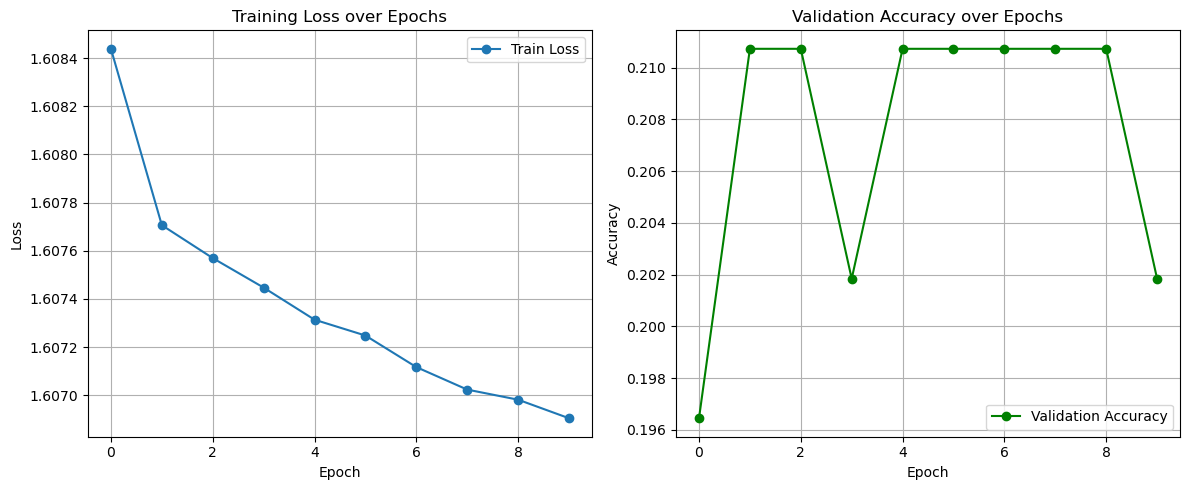

In [17]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Example review testing for model accuracy.

In [16]:
from nltk.tokenize import word_tokenize
import torch

# example 1: Very negative review, likely rating: 1
test_text_1 = "this is the worst product i have ever used. it broke in one day and was a total waste of money"
# example 2: Very positive review, likely rating: 5
test_text_2 = "absolutely amazing! this product exceeded all my expectations. highly recommended!"
# example 3: Mediocre review, likely rating: 3
test_text_3 = "i like some parts about this product, but it also has a few annoying issues"

test_texts = [test_text_1, test_text_2, test_text_3]

for i, text in enumerate(test_texts):
    test_tokens = word_tokenize(text.lower())
    test_bigrams = [f"{test_tokens[j]}_{test_tokens[j+1]}" for j in range(len(test_tokens)-1)]


    test_ids = [bigram2id.get(bg, bigram2id['<unk>']) for bg in test_bigrams]
    

    max_len = 256
    test_ids += [bigram2id['<pad>']] * (max_len - len(test_ids))


    test_tensor = torch.tensor([test_ids], dtype=torch.long)


    model.eval()
    with torch.no_grad():
        output = model(test_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    print(f"Example {i+1} - Review: \"{text}\"")
    print(f"Predicted Rating: {predicted_class + 1}")  # Adding 1 to shift to 1–5 scale
    print("—" * 60)


Example 1 - Review: "this is the worst product i have ever used. it broke in one day and was a total waste of money"
Predicted Rating: 5
————————————————————————————————————————————————————————————
Example 2 - Review: "absolutely amazing! this product exceeded all my expectations. highly recommended!"
Predicted Rating: 5
————————————————————————————————————————————————————————————
Example 3 - Review: "i like some parts about this product, but it also has a few annoying issues"
Predicted Rating: 5
————————————————————————————————————————————————————————————
